In [1]:
from keras.datasets.fashion_mnist import load_data
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Flatten
from keras.layers import Reshape
from tensorflow.keras.optimizers import Adam

In [2]:
from matplotlib import pyplot
from tqdm import tqdm
import numpy as np

# Setting up the Project

## Preparing the Dataset

In [3]:
def load_dataset():
    (trainX, _), (_, _) = load_data()
    dataset = np.expand_dims(trainX, axis=-1)
    dataset = dataset.astype('float32')
    dataset = dataset / 255.0
    return dataset

## Displaying the Dataset

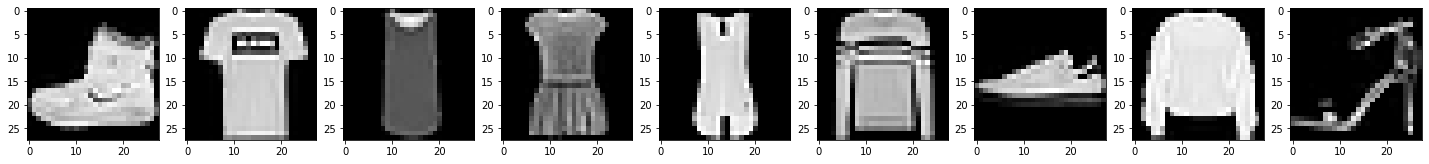

In [4]:
fig = pyplot.gcf()
fig.set_size_inches(25, 10.5)
fig.savefig('test2png.png', dpi=100)
x_train = load_dataset()

for i in range(9):
    pyplot.subplot(1,9,i + 1)
    pyplot.imshow(x_train[i],cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

## Create Batches

# Generating the GAN

## Creating the Discriminator

The purpose of a discriminator in a GAN is to determine how realistic an image looks. To do this both the real images from the training set, and generated images from the generator are passed into this model. By doing this the model is able to learn how to predict the likelihood that an image is real or not. This feature is very important, because it allows us to make sure that our generator produces realistic images. 

This discriminator takes in a 28 x 28 x 1 image and at the end will ouput the probabillity that an image is real. 

In [5]:
def discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(Dropout(0.4))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

## Creating the generator

The purpose of the generator is to generate data that could plausibly be from the original dataset. It's essentially trying to fool the discriminator. To do so, we will start with a vector, of latent_vecc_dim dimensions, that is instantiated with random values. The generator takes this vector and creates a set of low resolution images. We want it to be a set so the generator has space to combine values in multiple ways and learn from that.

Once that is done, the images are eventually upsampled to the target resolution 28 x 28.

In [6]:
def generator(latent_vec_dim):
    # Defining the model
    model = Sequential()
    
    # Input layer, takes in a vector with latent_dim dimensions 
    # and has enough nodes for multiple versions of low resolution
    # images. Picking a standard number like 128, we need 256x28x28 nodes.
    num_nodes = 128*7*7
    
    model.add(Dense(num_nodes, input_dim = latent_vec_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    
    # now upsample the low res 7x7 image to 14x14 image
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

## Creating the GAN

The GAN is a compound model consisting of the generator and then the discriminator in that order. The discriminator is not trainable in the GAN because we are targeting the generator, and having weights that change in the discriminator after every datapoint is not a viable way of training it. That being said the discriminator does get trained every epoch, just not here.

In [7]:
def gan(disc, gen):
    disc.trainable = False
    
    model =Sequential()
    model.add(gen)
    model.add(disc)
    
    optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

## Helper methods for training

In [8]:
def pick_samples(dataset, num_samples):
    ix = np.random.randint(0, dataset.shape[0], num_samples)
    X = dataset[ix]
    y = np.ones((num_samples, 1))
    return X, y

In [9]:
def generate_latent_vec(latent_vec_dim, num_vec):
    latent_vecs = np.random.randn(latent_vec_dim * num_vec)
    latent_vecs = latent_vecs.reshape(num_vec, latent_vec_dim)
    return latent_vecs

In [10]:
def generate_samples(generator, latent_vec_dim, num_vec):
    latent_vecs = generate_latent_vec(latent_vec_dim, num_vec)
    X = generator.predict(latent_vecs)
    y = np.zeros((num_vec, 1))
    return X, y

## What does an untrained generator generate?

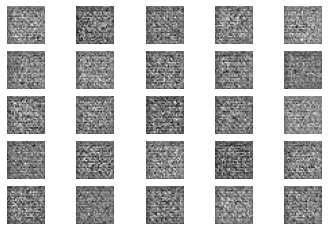

In [11]:
latent_vec_dim = 100
gen = generator(latent_vec_dim)
X, _ = generate_samples(gen, latent_vec_dim, 25)
for i in range(25):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
pyplot.show()

## Train the model

Now that we have the individual components ready we should train the model.

In [12]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in tqdm(range(n_epochs), position=0, desc="i", leave=False, colour='green', ncols=80):
        for j in tqdm(range(bat_per_epo), position=1, desc="j", leave=False, colour='red', ncols=80):
            X_real, y_real = pick_samples(dataset, half_batch)
            X_fake, y_fake = generate_samples(g_model, latent_dim, half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_vec(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

In [13]:
latent_vec_dim = 100
disc = discriminator()
gen = generator(latent_vec_dim)
gan = gan(disc, gen)
dataset = load_dataset()

In [14]:
train(gen, disc, gan, dataset, 100)

j:   3%|█                                       | 6/234 [00:12<07:16,  1.91s/it]


KeyboardInterrupt: 

In [ ]:
X, _ = generate_samples(gen, latent_vec_dim, 25)
for i in range(25):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
pyplot.show()

In [ ]:
filename = 'fashion_mnist_generator.h5'
gen.save(filename)